In [65]:
import time
import os
import cv2
import pandas as pd

import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

'''from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *'''

'from lib.file.TIF import *\nfrom lib.analysis.ROI_identification import *\nfrom lib.file.ROI_writer import ROIFileWriter\nfrom lib.file.ROI_reader import ROIFileReader\nfrom lib.file.TSV import RegionExporter\nfrom lib.analysis.align import ImageAlign\nfrom lib.file.DAT import TracesDAT\nfrom lib.trace import Tracer\nfrom lib.utilities import *\nfrom lib.analysis.laminar_dist import *'

In [66]:
# group each population (direct stim, monosynaptic, disynaptic)
synapse_count_map = {
    '10_02_2020 02_01_05 Inter 2_3': {
        0: [],
        1: [i for i in range(12)],
        2: [i for i in range(12, 16)]
    },
    '10_27_2020 03_01_06 Intra 4': {
        0: [i for i in range(4)],
        1: [i for i in range(4, 16)],
        2: []
    },
    '10_29_2020 04_01_01 Inter 4': {
        0: [i for i in range(5)] + [8, 9],
        1: [5,6,7,10,11],
        2: []
    },
    '12_13_2020 02_01_02 Intra 4': {
        0: [17],
        1: [i for i in range(4)] + [i for i in range(12, 17)] + [18],
        2: [i for i in range(4, 12)]
    },
    '12_28_2020 03_01_08 Intra 2_3': {
        0: [1, 12],
        1: [0, 2, 6, 7, 10, 11, 13, 14],
        2: [3, 4, 5, 8, 9]
    },
    '12_29_2020 04_01_01 Inter 4' : {
        0: [],
        1: [i for i in range(11,16)],
        2: [i for i in range(11)]
    },
    '01_11_2021 09_01_01 Inter 2_3': {
        0: [],
        1: [],
        2: [i for i in range(14)]
    },
    '01_18_2021 04_01_02 Inter 2_3': {
        0: [22, 23],
        1: [i for i in range(13)],
        2: [i for i in range(14, 22)] + [24, 25]
    },
    '01_19_2021 05_01_01 Inter 2_3': {
        0: [20],
        1: [],
        2: [i for i in range(20)] + [21]
    },
    '03_02_2021 03_01_02 Inter 5': {
        0: [21],
        1: [i for i in range(21)] + [22, 23],
        2: []
    },
    '03_09_2021 03_01_02 Inter 5': {
        0: [],
        1: [i for i in range(22)],
        2: []
    },
    '03_23_2021 05_01_02 Intra 5': {
        0: [8,13, 14, 16, 17],
        1: [i for i in range(8)] + [i for i in range(9,12)],
        2: [12,15]
    },
    '04_13_2021 03_01_02 Inter 5': {
        0: [],
        1: [i for i in range(16)],
        2: []
    },
    '05_25_2021 01_01_04 Intra 2_3': {
        0: [],
        1: [i for i in range(12)] + [13,16],
        2: [12,14,15,17]
    },
    '05_26_2021 02_01_04 Inter 2_3': {
        0: [],
        1: [i for i in range(6)] + [7,8,9,11, 17],
        2: [6, 10] + [i for i in range(12,17)]
    },
    '05_31_2021 05_01_04 Inter 5': {
        0: [],
        1: [i for i in range(21)],
        2: [i for i in range(21,28)]
    },
    '06_28_2021 03_01_02 Inter 5': {
        0: [],
        1: [i for i in range(26)],
        2: []
    },
    '06_29_2021 02_01_02 Inter 5': {
        0: [22],
        1: [i for i in range(22)],
        2: []
    },
    '08_06_2021 02_01_02 Inter 4': {
        0: [15, 21, 22],
        1: [i for i in range(15)] + [16,17,18,19,20,23],
        2: []
    },
    '08_09_2021 05_01_06 Inter 4': {
        0: [21],
        1: [i for i in range(21)],
        2: []
    },
    '08_31_2021 03_01_02 Inter 2_3': {
        0: [],
        1: [i for i in range(22)],
        2: []
    },
    '09_06_2021 02_01_06 Inter 2_3': {
        0: [],
        1: [i for i in range(6)],
        2: [i for i in range(6,22)]
    }
}

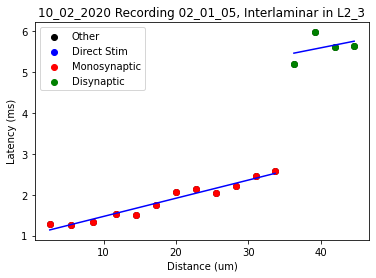

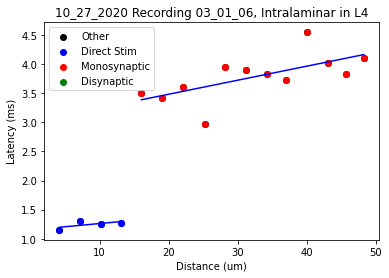

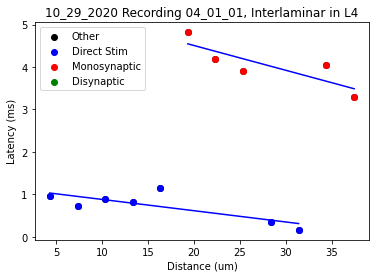

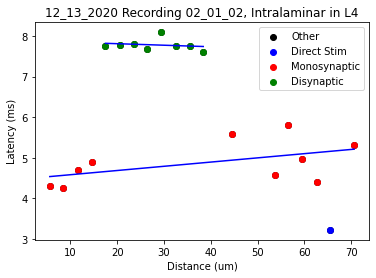

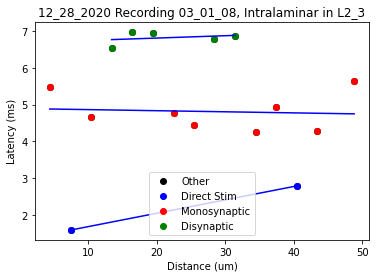

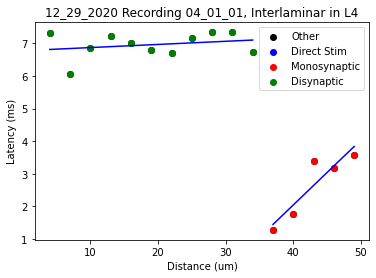

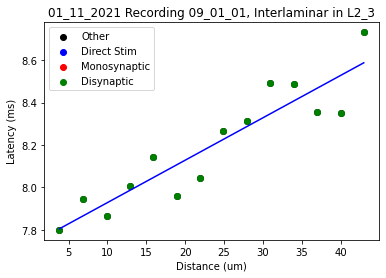

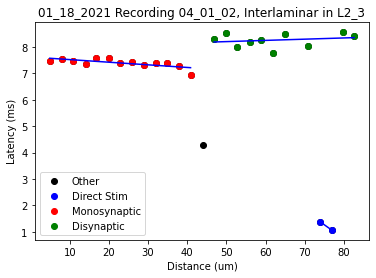

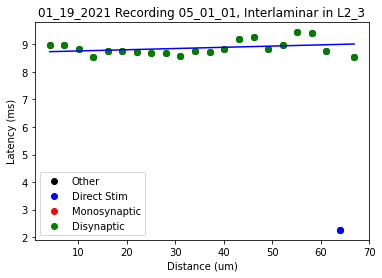

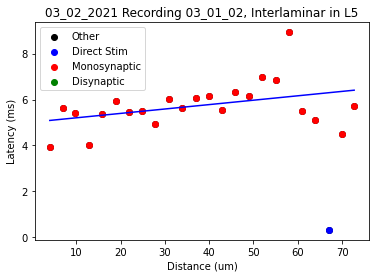

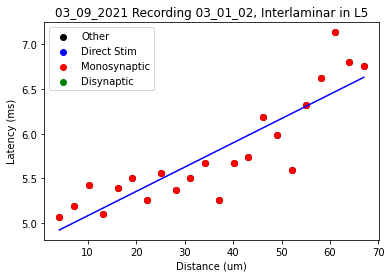

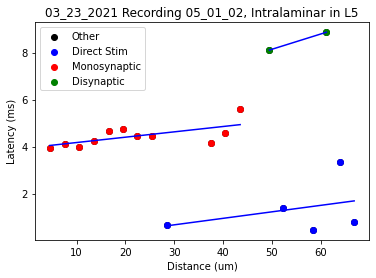

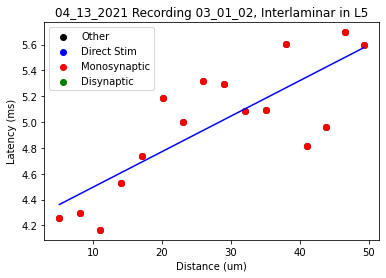

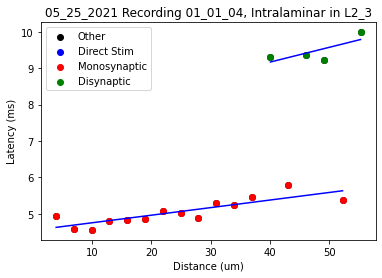

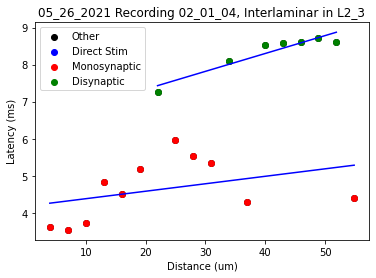

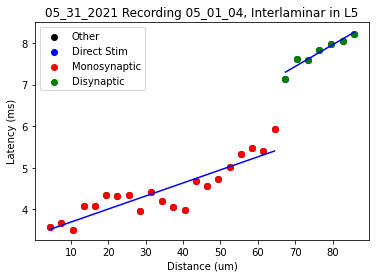

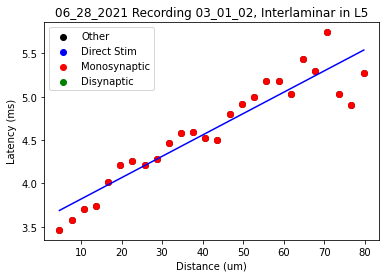

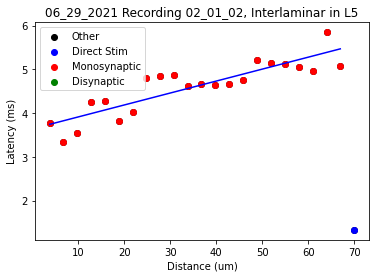

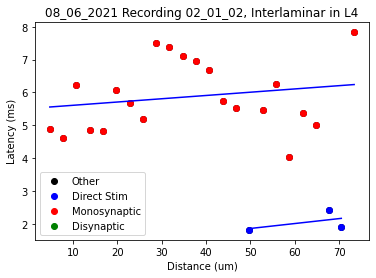

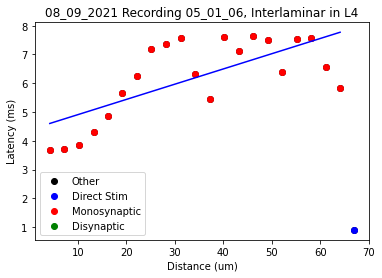

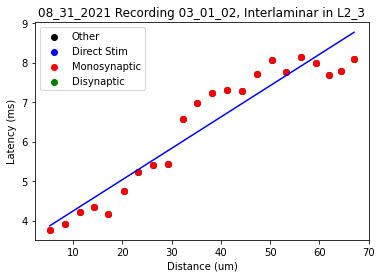

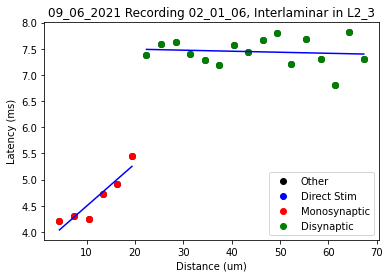

In [74]:
# Load data, for any Google Drive for desktop
data_dir = "G:/.shortcut-targets-by-id/"
dir_name = 'Choosing trajectories'
filename = 'raw_velocity_data.csv'
depth_limit = 4

# just finding the dir
for subdir, dirs, files in os.walk(data_dir):
    depth = subdir.count('/') + subdir.count('\\')
    if depth > depth_limit:  # don't care about any deeper dir
        continue
    if 'Choosing trajectories' in subdir:
        filename = subdir + '/' + filename
        break
        
df = pd.read_csv(filename)
df = pd.DataFrame(df, columns=['Date', 'Age_Days', 'Sex', 'Tx', 'Slice_Loc_Run',
                              'Trial_x_Time', 'Stim_Intensity', 'Cx', 'n_Pulses',
                              'Stim_Layer', 'Laminar', 'ROI_Id', 'SNR', 
                               'Latency_Raw', 'Latency_Calc', 'Distance'])

df['Latency_Calc'] = df['Latency_Raw'] - 46.0  # 46 ms is stim time
df.drop(df[df['Latency_Calc'] <= 0].index, inplace=True)  # negative values are non-physical

colors = ['b', 'r', 'g']
# for each recording/laminar/direction measurement, plot latency vs distance
for date in df.Date.unique():
    cv_subset = df[(df['Date'] == date)]
    for rec_id in cv_subset.Slice_Loc_Run.unique():
        cv_subset = cv_subset[(cv_subset['Slice_Loc_Run'] == rec_id)]
        for laminar_val in cv_subset.Laminar.unique():
            cv_subset = cv_subset[(cv_subset['Laminar'] == laminar_val)]
            for layer_val in cv_subset.Stim_Layer.unique():
                cv_subset = cv_subset[(cv_subset['Stim_Layer'] == layer_val)]
                plot_key = date + " " + rec_id + " " + laminar_val + " " + layer_val
                
                plt.clf()
                plt.scatter(cv_subset['Distance'], 
                            cv_subset['Latency_Calc'],
                            c='black')
                
                # analyze and plot each synapse-count group separately
                reg_lines = []
                for i_synap in [0, 1, 2]:
                    ind_list = synapse_count_map[plot_key][i_synap]
                    syn_cv_subset = cv_subset.iloc[ind_list]
                    dist = np.array(syn_cv_subset['Distance']).reshape(-1, 1)
                    latency = np.array(syn_cv_subset['Latency_Calc']).reshape(-1, 1)
                    plt.scatter(dist, latency, c=colors[i_synap])

                    if dist.size > 1:
                        regr = linear_model.LinearRegression()
                        regr.fit(dist, latency)
                        y_pred = regr.predict(dist)
                        reg_lines.append([dist, y_pred])
                
                plt.legend(["Other","Direct Stim", "Monosynaptic", "Disynaptic"])
                for i in reg_lines:
                    dist, y_pred = rl
                    plt.plot(dist, y_pred, c='b')
                    print("Slope"
    
                
                plt.title(date + " Recording " + rec_id + ", " + laminar_val + "laminar in L" + layer_val)
                plt.xlabel('Distance (um)')
                plt.ylabel('Latency (ms)')
                plt.show()